**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Production economy and CO2 taxation](#toc1_)    
- 2. [Problem 2: Career choice model](#toc2_)    
- 3. [Problem 3: Barycentric interpolation](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# Write your code here
%load_ext autoreload
%autoreload all
import numpy as np
from types import SimpleNamespace
from scipy.optimize import fsolve
from scipy.optimize import minimize
import sympy as sm
import scipy as sp
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import optimize
from scipy import interpolate

## 1. <a id='toc1_'></a>[Problem 1: Production economy and CO2 taxation](#toc0_)

Consider a production economy with two firms indexed by $j \in \{1,2\}$. Each produce its own good. They solve

$$
\begin{align*}
\max_{y_{j}}\pi_{j}&=p_{j}y_{j}-w_{j}\ell_{j}\\\text{s.t.}\;&y_{j}=A\ell_{j}^{\gamma}.
\end{align*}
$$

Optimal firm behavior is

$$
\begin{align*}
\ell_{j}^{\star}(w,p_{j})&=\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}} \\
y_{j}^{\star}(w,p_{j})&=A\left(\ell_{j}^{\star}(w,p_{j})\right)^{\gamma}
\end{align*}
$$

The implied profits are

$$
\pi_{j}^*(w,p_{j})=\frac{1-\gamma}{\gamma}w\cdot\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}}
$$

A single consumer supplies labor, and consumes the goods the firms produce. She also recieves the implied profits of the firm.<br>
She solves:

$$
\begin{align*}
U(p_1,p_2,w,\tau,T) = \max_{c_{1},c_{2},\ell} & \log(c_{1}^{\alpha}c_{2}^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} \\
\text{s.t.}\,\,\,&p_{1}c_{1}+(p_{2}+\tau)c_{2}=w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})
\end{align*}
$$

where $\tau$ is a tax and $T$ is lump-sum transfer. <br>
For a given $\ell$, it can be shown that optimal behavior is

$$
\begin{align*}
c_{1}(\ell)&=\alpha\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{1}} \\
c_{2}(\ell)&=(1-\alpha)\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{2}+\tau} \\
\end{align*}
$$
Such that optimal behavior is:
$$
\ell^* = \underset{\ell}{\arg\max} \log(\left(c_{1}(\ell)\right)^{\alpha}\cdot \left(c_{2}(\ell)\right)^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} 
$$
With optimal consumption:
$$
\begin{align*}
c_1^*=c_{1}(\ell^*) \\
c_2^*=c_{2}(\ell^*)\\
\end{align*}
$$


The government chooses $\tau$ and balances its budget so $T=\tau c_2^*$. We initially set $\tau,T=0$.

Market clearing requires:

1. Labor market: $\ell^* = \ell_1^* + \ell_2^*$
1. Good market 1: $c_1^* = y_1^*$
1. Good market 2: $c_2^* = y_2^*$


**Question 1:** Check market clearing conditions for $p_1$ in `linspace(0.1,2.0,10)` and $p_2$ in `linspace(0.1,2.0,10)`. We choose $w=1$ as numeraire.

In [2]:
par = SimpleNamespace()
# firms
par.A = 1.0
par.gamma = 0.5
# households
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0
# government
par.tau = 0.0
par.T = 0.0
# Question 3
par.kappa = 0.1

Defining given functions

In [3]:

#Optimal firm behaviour
def l_demand(p_i): #Labor demand for each firm.
  return (p_i*par.A*par.gamma)**(1/(1-par.gamma))

def y_supply(p_i): #Goods supply for each firm.
  return par.A*(l_demand(p_i))**par.gamma

def profits(p_i): #Profits for each firm
  return (1-par.gamma)/(par.gamma)*l_demand(p_i)

#Optimal cosumption

def income(l,p1,p2):  #Income of the agent
  return l+par.tau*y_supply(p2)+profits(p1)+profits(p2)

def c_1(l,p1,p2): #Consumption of good 1
  return par.alpha*((l+par.tau*y_supply(p2)+profits(p1)+profits(p2))/p1)

def c_2(l,p1,p2): #Consumption of good 2
  return (1-par.alpha)*((l+par.tau*y_supply(p2)+profits(p1)+profits(p2))/(p2+par.tau))

In order to define market clearing conditions, we need to find the optimal supply of labor, as the labor market condition is that labor demand equal labor supply. In the following code we solve the first order condition of labor supply numerically with fsolve.

In [4]:

# optimal supply of labor
def maximize_l_star(p1,p2,initial_guess):
    # Define the derivative function to be zeroed. We have solved the optimal labour supply maximization problem algebraic and the result is the return.
    def derivative(l):
        return (par.alpha)/(income(l,p1,p2))+(1-par.alpha)/(income(l,p1,p2))-par.nu*l**(par.epsilon)

    # Use fsolve to find the root of the derivative function
    l_star, = fsolve(derivative, initial_guess)
    return l_star

Now we check market clearing conditions for different sets of prices

In [5]:

# Checking market clearing conditions for different prices p1 and p2
for i in np.linspace(0.1,2.0,10):
  for j in np.linspace(0.1,2.0,10):
    l_star = maximize_l_star(i,j,0)
    c1 = c_1(l_star,i,j)
    c2 = c_2(l_star,i,j)
    l1 = l_demand(i)
    l2 = l_demand(j)
    y1 = y_supply(i)
    y2 = y_supply(j)


    # market clearing conditions
    labor_market_clearing = l_star-l1-l2
    good_market_1_clearing = c1-y1
    good_market_2_clearing = c2-y2

    if abs(labor_market_clearing) < 0.5 and abs(good_market_1_clearing) < 0.5 and abs(good_market_2_clearing) < 0.5:
      print(f"p1={i:.1f}, p2={j:.1f} -> Labor: {labor_market_clearing:.4f}, Goods1: {good_market_1_clearing:.4f}, Goods2: {good_market_2_clearing:.4f}")

p1=0.5, p2=1.2 -> Labor: 0.4804, Goods1: 0.4767, Goods2: 0.2003
p1=0.7, p2=1.2 -> Labor: 0.3975, Goods1: 0.1791, Goods2: 0.2304
p1=0.7, p2=1.4 -> Labor: 0.2331, Goods1: 0.2208, Goods2: 0.0521
p1=0.7, p2=1.6 -> Labor: 0.0444, Goods1: 0.2707, Goods2: -0.0977
p1=0.7, p2=1.8 -> Labor: -0.1678, Goods1: 0.3293, Goods2: -0.2288
p1=0.7, p2=2.0 -> Labor: -0.4025, Goods1: 0.3969, Goods2: -0.3468
p1=0.9, p2=1.2 -> Labor: 0.2879, Goods1: -0.0270, Goods2: 0.2712
p1=0.9, p2=1.4 -> Labor: 0.1252, Goods1: 0.0059, Goods2: 0.0876
p1=0.9, p2=1.6 -> Labor: -0.0618, Goods1: 0.0452, Goods2: -0.0662
p1=0.9, p2=1.8 -> Labor: -0.2722, Goods1: 0.0912, Goods2: -0.2003
p1=1.2, p2=1.2 -> Labor: 0.1522, Goods1: -0.1916, Goods2: 0.3233
p1=1.2, p2=1.4 -> Labor: -0.0085, Goods1: -0.1642, Goods2: 0.1326
p1=1.2, p2=1.6 -> Labor: -0.1934, Goods1: -0.1315, Goods2: -0.0263
p1=1.2, p2=1.8 -> Labor: -0.4018, Goods1: -0.0934, Goods2: -0.1643
p1=1.4, p2=1.2 -> Labor: -0.0085, Goods1: -0.3336, Goods2: 0.3872
p1=1.4, p2=1.4 -> L

We find that no set of prices fully clear all markets. Above result is showing only the results that are closest to clearing all markets. The grit search is relatively coarse, so we dont find any clearing prices.

**Question 2:** Find the equilibrium prices $p_1$ and $p_2$.<br>
*Hint: you can use Walras' law to only check 2 of the market clearings*

In [6]:
# Objective function to minimize the sum of squares of market clearing conditions
def objective_function(params):
    p1, p2 = params
    l_star = maximize_l_star(p1,p2,0)
    c1 = c_1(l_star,p1,p2)
    c2 = c_2(l_star,p1,p2)
    y1 = y_supply(p1)
    y2 = y_supply(p2)
    return (c1-y1)**2 + (c2-y2)**2

# Initial guess for p1 and p2
initial_guess = [1.0, 1.0]

# Use minimize to find the equilibrium prices
result = minimize(objective_function, initial_guess, method='Nelder-Mead')

# Print the equilibrium prices
if result.success:
    equilibrium_prices = result.x
    print(f"Equilibrium prices: p1 = {equilibrium_prices[0]:.4f}, p2 = {equilibrium_prices[1]:.4f}")
else:
    print("Optimization did not converge.")

Equilibrium prices: p1 = 0.9759, p2 = 1.4907


In [7]:
#Check if market clears

def check_clearing(p1,p2):
    l_star = maximize_l_star(p1,p2,0)
    c1 = c_1(l_star,p1,p2)
    c2 = c_2(l_star,p1,p2)
    l1 = l_demand(p1)
    l2 = l_demand(p2)
    y1 = y_supply(p1)
    y2 = y_supply(p2)

    labor_market_clearing = l_star-l1-l2
    good_market_1_clearing = c1-y1
    good_market_2_clearing = c2-y2

    print(f"p1={p1:.3f}, p2={p2:.3f} -> Labor: {labor_market_clearing:.4f}, Goods1: {good_market_1_clearing:.4f}, Goods2: {good_market_2_clearing:.4f}")

In [124]:
check_clearing(equilibrium_prices[0],equilibrium_prices[1])

p1=0.976, p2=1.491 -> Labor: 0.0000, Goods1: -0.0000, Goods2: 0.0000


I.e. these equilibrium prices clear all markets.

Assume the government care about the social welfare function:

$$
SWF = U - \kappa y_2^*
$$

Here $\kappa$ measures the social cost of carbon emitted by the production of $y_2$ in equilibrium.

**Question 3:** What values of $\tau$ and (implied) $T$ should the government choose to maximize $SWF$?

In [8]:

# Maximizing the SWF with grid search
SWF_best = -9999
for i in np.linspace(0,1,500):

  par.tau = i
  result = minimize(objective_function, initial_guess, method='Nelder-Mead') #Finding prices for level of tau
  equilibrium_prices = result.x
  l_star = maximize_l_star(equilibrium_prices[0],equilibrium_prices[1],0) # Optimal labor supply given tau and prices
  c1 = c_1(l_star,equilibrium_prices[0],equilibrium_prices[1]) # Optimal consumption of good 1
  c2 = c_2(l_star,equilibrium_prices[0],equilibrium_prices[1]) # Optimal consumption of good 2
  U = np.log(c1**par.alpha*c2**(1-par.alpha))-par.nu*(l_star**(1+par.epsilon))/(1+par.epsilon) #Calculating utilty
  SWF = (U-par.kappa*c2) #Calculating SWF
  if SWF > SWF_best:
    SWF_best = SWF
    tau_best = i
    T = tau_best*c2

print(SWF_best,tau_best) # Tau that maximize
print(T)

-0.661083108190528 0.16432865731462926
0.1189758507375911


So that the level of tau that maximizes the social welfare function is 16,7%, and the total tax pool T is 0.12.

## 2. <a id='toc2_'></a>[Problem 2: Career choice model](#toc0_)

Consider a graduate $i$ making a choice between entering $J$ different career tracks. <br>
Entering career $j$ yields utility $u^k_{ij}$. This value is unknown to the graduate ex ante, but will ex post be: <br>
$$
    u_{i,j}^k = v_{j} + \epsilon_{i,j}^k
$$

They know that $\epsilon^k_{i,j}\sim \mathcal{N}(0,\sigma^2)$, but they do not observe $\epsilon^k_{i,j}$ before making their career choice. <br>

Consider the concrete case of $J=3$ with:
$$
\begin{align*}
    v_{1} &= 1 \\
    v_{2} &= 2 \\
    v_{3} &= 3
\end{align*}
$$

If the graduates know the values of $v_j$ and the distribution of $\epsilon_{i,j}^k$, they can calculate the expected utility of each career track using simulation: <br>
$$
    \mathbb{E}\left[ u^k_{i,j}\vert v_j \right] \approx v_j + \frac{1}{K}\sum_{k=1}^K \epsilon_{i,j}^k
$$

In [10]:
par = SimpleNamespace()
par.J = 3
par.N = 10
par.K = 10000

par.F = np.arange(1,par.N+1)
par.sigma = 2

par.v = np.array([1,2,3])
par.c = 1

**Question 1:** Simulate and calculate expected utility and the average realised utility for $K=10000$ draws, for each career choice $j$.


### Comments ###

 - Each career choice is has an increasing value, of 1, 2 and 3. The error terms gives slight variation, but it is still expected for career 3 to have the highest utility
 - Because of the wording we assume "calculate expected utility" and "average realised utility" is not the same. We assume expected utility are for each graduate, since the error term in the expected utility changes for each i (for each student) in the formula given. Therefore a **student** draws 10000 expectations for each career choice. The average realised utility is the average of each career choice given the 10 students expectations for each career.

In [11]:
np.random.seed(2024) # define a seed, so we can replicate simulate error term

#mean_of_career = np.mean(np.mean(epsilon, axis=1), axis=1) # find the mean of each career, so we get 3 lists of 10 people.
graduate_mean_career = np.zeros((par.N, par.J))
for i in range(par.N):
    epsilon = np.random.normal(0, par.sigma, (par.K, par.J)) # simulation with mean 0 and given sigma of 2. We have 3 careers, 10 people and 10000 repetitions.
    mean_of_career = np.mean(epsilon, axis=0) # find the mean of each career.
    graduate_mean_career[i, :] = mean_of_career

average_realised_utility = np.mean(graduate_mean_career,axis=0) # average over all graduates
for j in range(par.J):
      average_realised_utility[j] += 1+j

graduate = 0

for i in graduate_mean_career:
        print("Graduate " + str(graduate+1) + " expects the following values for career 1, 2, 3: "
              + str(round(graduate_mean_career[graduate][0],4)+1) + " , " +
              str(round(graduate_mean_career[graduate][1],4)+2) + " , " +
              str(round(graduate_mean_career[graduate][2],4)+3) + " , respectively.")
        graduate += 1

print("The average realised utility for career 1, 2, 3 is: " +
      str(round(average_realised_utility[0],4)) + " , " +
      str(round(average_realised_utility[1],4)) + " , " +
      str(round(average_realised_utility[2],4)) + " , respectively" )

Graduate 1 expects the following values for career 1, 2, 3: 1.0195 , 1.9924 , 3.0128 , respectively.
Graduate 2 expects the following values for career 1, 2, 3: 1.0088 , 2.0178 , 3.0145 , respectively.
Graduate 3 expects the following values for career 1, 2, 3: 0.9748 , 1.9896 , 3.0065 , respectively.
Graduate 4 expects the following values for career 1, 2, 3: 1.0103 , 2.0052 , 3.0267 , respectively.
Graduate 5 expects the following values for career 1, 2, 3: 0.9594 , 2.0242 , 3.0191 , respectively.
Graduate 6 expects the following values for career 1, 2, 3: 1.0032 , 1.9888 , 3.0001 , respectively.
Graduate 7 expects the following values for career 1, 2, 3: 1.0093 , 1.9938 , 3.0008 , respectively.
Graduate 8 expects the following values for career 1, 2, 3: 1.0076 , 2.0278 , 2.9966 , respectively.
Graduate 9 expects the following values for career 1, 2, 3: 0.9845 , 2.0061 , 3.0196 , respectively.
Graduate 10 expects the following values for career 1, 2, 3: 0.9963 , 2.0301 , 3.0126 , res

**Conclusion**

- We see career choice 3 has the highest utility

Now consider a new scenario: Imagine that the graduate does not know $v_j$. The *only* prior information they have on the value of each job, comes from their $F_{i}$ friends that work in each career $j$. After talking with them, they know the average utility of their friends (which includes their friends' noise term), giving them the prior expecation: <br>
$$
\tilde{u}^k_{i,j}\left( F_{i}\right) = \frac{1}{F_{i}}\sum_{f=1}^{F_{i}} \left(v_{j} + \epsilon^k_{f,j}\right), \; \epsilon^k_{f,j}\sim \mathcal{N}(0,\sigma^2)
$$
For ease of notation consider that each graduate have $F_{i}=i$ friends in each career. <br>

For $K$ times do the following: <br>
1. For each person $i$ draw $J\cdot F_i$ values of $\epsilon_{f,j}^{k}$, and calculate the prior expected utility of each career track, $\tilde{u}^k_{i,j}\left( F_{i}\right)$. <br>
Also draw their own $J$ noise terms, $\epsilon_{i,j}^k$
1. Each person $i$ chooses the career track with the highest expected utility: $$j_i^{k*}= \arg\max_{j\in{1,2\dots,J}}\left\{ \tilde{u}^k_{i,j}\left( F_{i}\right)\right\} $$
1. Store the chosen careers: $j_i^{k*}$, the prior expectation of the value of their chosen career: $\tilde{u}^k_{i,j=j_i^{k*}}\left( F_{i}\right)$, and the realized value of their chosen career track: $u^k_{i,j=j_i^{k*}}=v_{j=j_i^{k*}}+\epsilon_{i,j=j_i^{k*}}^k$.

Chosen values will be: <br>
$i\in\left\{1,2\dots,N\right\}, N=10$ <br>
$F_i = i$<br>
So there are 10 graduates. The first has 1 friend in each career, the second has 2 friends, ... the tenth has 10 friends.

**Question 2:** Simulate and visualize: For each type of graduate, $i$, the share of graduates choosing each career, the average subjective expected utility of the graduates, and the average ex post realized utility given their choice. <br>
That is, calculate and visualize: <br>
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \mathbb{I}\left\{ j=j_i^{k*} \right\}  \;\forall j\in\left\{1,2,\dots,J\right\}
\end{align*}
$$
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \tilde{u}^k_{ij=j_i^{k*}}\left( F_{i}\right)
\end{align*}
$$
And 
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} u^k_{ij=j_i^{k*}} 
\end{align*}
$$
For each graduate $i$.

## Comments ##
 - Each friend has an error term given by epsilon_friends, that is normally distributed with mean 0 and std dev of 2.

 - We notice the friends have their own error term, that also impacts on the graduates own utility + the graduates own additional error term
 
 - Each friend is unique and graduates don't inherit friends between the same career options. (easy to adjust, if you want inheritance, just provide a list instead of a generator)
 
 - Then their prior utility is calculated, and at last their chosen career track of which gives the highest yield, given the mean of their friends.yield.

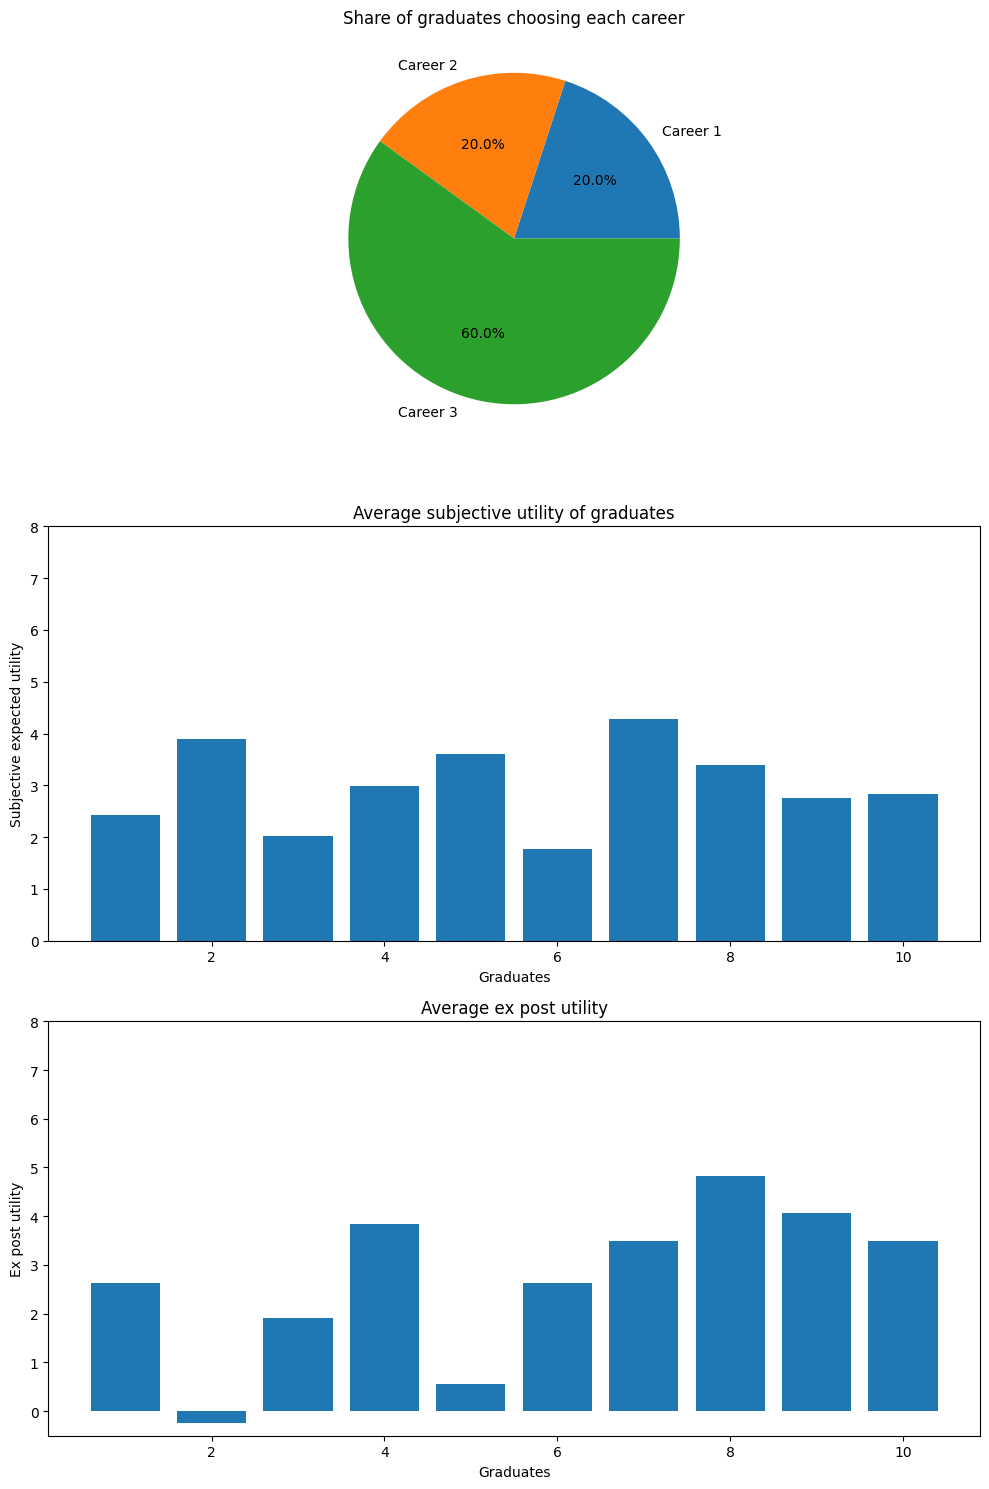

In [12]:
np.random.seed(2023)

def epsilon_friends(amount_of_friends): # generator for error term for friends
    # there is no inheritence between individual i's friend and i+1's friend!
    return np.random.normal(0, par.sigma, (amount_of_friends, par.J))


def epsilon_graduates():
    global epsilon_graduates_list
    epsilon_graduates_list = np.zeros((par.N, par.J))
    
    for i in range(len(epsilon_graduates_list)):
        epsilon_graduates_list[i] = np.random.normal(0, par.sigma, par.J)
    
    return epsilon_graduates_list


def average_utility_friends_function(): # function to calculate the subjective utility from friends
    global average_utility_friends

    average_utility_friends = np.zeros((par.N, par.J)) # define array of friends x career options

    for i in range(1,par.N+1): # loop over number of friends each graduate has
        draw_friends = epsilon_friends(i) # draw error term for friends, and gives a list based on the amount of friends i.
        average_utility_friends[i-1, :] = np.mean(draw_friends, axis=0) # add the mean of the drawn error terms to the list
    
    for v in par.v:
        average_utility_friends[:,v-1] += v # add the actual utility of the career

    return average_utility_friends


def share_of_career_selection(): # calculate proportions of graduates that chooses careers
    global career_selection
    career_selection = np.argmax(average_utility_friends, axis=1) + 1 # select the career with highest utility, based on friends averaged utility

    career_share = np.zeros(par.J) # define array to store career shares
    for i in range(par.J):
        career_share[i] = np.count_nonzero(career_selection == i+1) / par.N # if career is in the career_selection list, then count it. Divide by number of graduates to get proportion

    return career_share


def exp_post_graduates_utility():

    global utility_of_career_choice
    utility_of_career_choice = np.zeros(par.N)

    for i in range(par.N):
        for v in par.v:
            if career_selection[i] == v:
                utility_of_career_choice[i] = v + epsilon_graduates()[i][v-1]
    return utility_of_career_choice

fig, axs = plt.subplots(3, 1, figsize=(10, 15)) # initialize 3 subplots

axs[1].bar(np.arange(1, par.N+1), np.max(average_utility_friends_function(), axis=1), label='Career 1') # average subjective expected utility

axs[1].set_title('Average subjective utility of graduates')
axs[1].set_xlabel('Graduates')
axs[1].set_ylabel('Subjective expected utility')
axs[1].set_ylim(top=8)

axs[0].pie(share_of_career_selection(), labels=[f'Career {j+1}' for j in range(par.J)],autopct='%1.1f%%') # pie chart of career proportions
axs[0].set_title('Share of graduates choosing each career')

axs[2].bar(np.arange(1, par.N+1), exp_post_graduates_utility()) # average ex post realized utility
axs[2].set_title('Average ex post utility')
axs[2].set_xlabel('Graduates')
axs[2].set_ylabel('Ex post utility')
axs[2].set_ylim(top=8)

plt.tight_layout()
plt.show()

**Conclusion**

 - The pie chart shows a distribution of 10% career 1, 30% career 2 and 40% career 3.

 - The  outlier for career 1 is because of the high expectation given from his single friend from career 1, as seen on the expected utility. This results in 

 - For each graduate increase in friends, we expect the deviation to go away and the true nature of career 3 with the highest utility is to be expected.

 - The graduates own error term can also weigh high. For graduate 7 it can be seen, with a very high ex ante utility of 6.57, although his expectations are defined by his friends choice.

After a year of working in their career, the graduates learn $u^k_{ij}$ for their chosen job $j_i^{k*}$ perfectly. <br>
The can switch to one of the two remaining careers, for which they have the same prior as before, but it will now include a switching cost of $c$ which is known.
Their new priors can be written as: 
$$
\tilde{u}^{k,2}_{ij}\left( F_{i}\right) = \begin{cases}
            \tilde{u}^k_{ij}\left( F_{i}\right)-c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

We will set $c=1$.

Their realized utility will be: <br>
$$
u^{k,2}_{ij}= \begin{cases}
            u_{ij}^k -c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

**Question 3:** Following the same approach as in question 2, find the new optimal career choice for each $i$, $k$. Then for each $i$, calculate the average subjective expected utility from their new optimal career choice, and the ex post realized utility of that career. Also, for each $i$, calculate the share of graduates that chooses to switch careers, conditional on which career they chose in the first year. <br>

Graduate 2 switched to career 3 from career 1
Graduate 5 switched to career 3 from career 2
Graduate 9 switched to career 2 from career 3
List of career selections before switch: [1 1 3 3 2 2 3 3 3 3]
List of career selections after switch: [1 3 3 3 3 2 3 3 2 3]
Share of graduates in career 1 that chose to switch career from last year: 0.5
Share of graduates in career 2 that chose to switch career from last year: 0.5
Share of graduates in career 3 that chose to switch career from last year: 0.16666666666666666


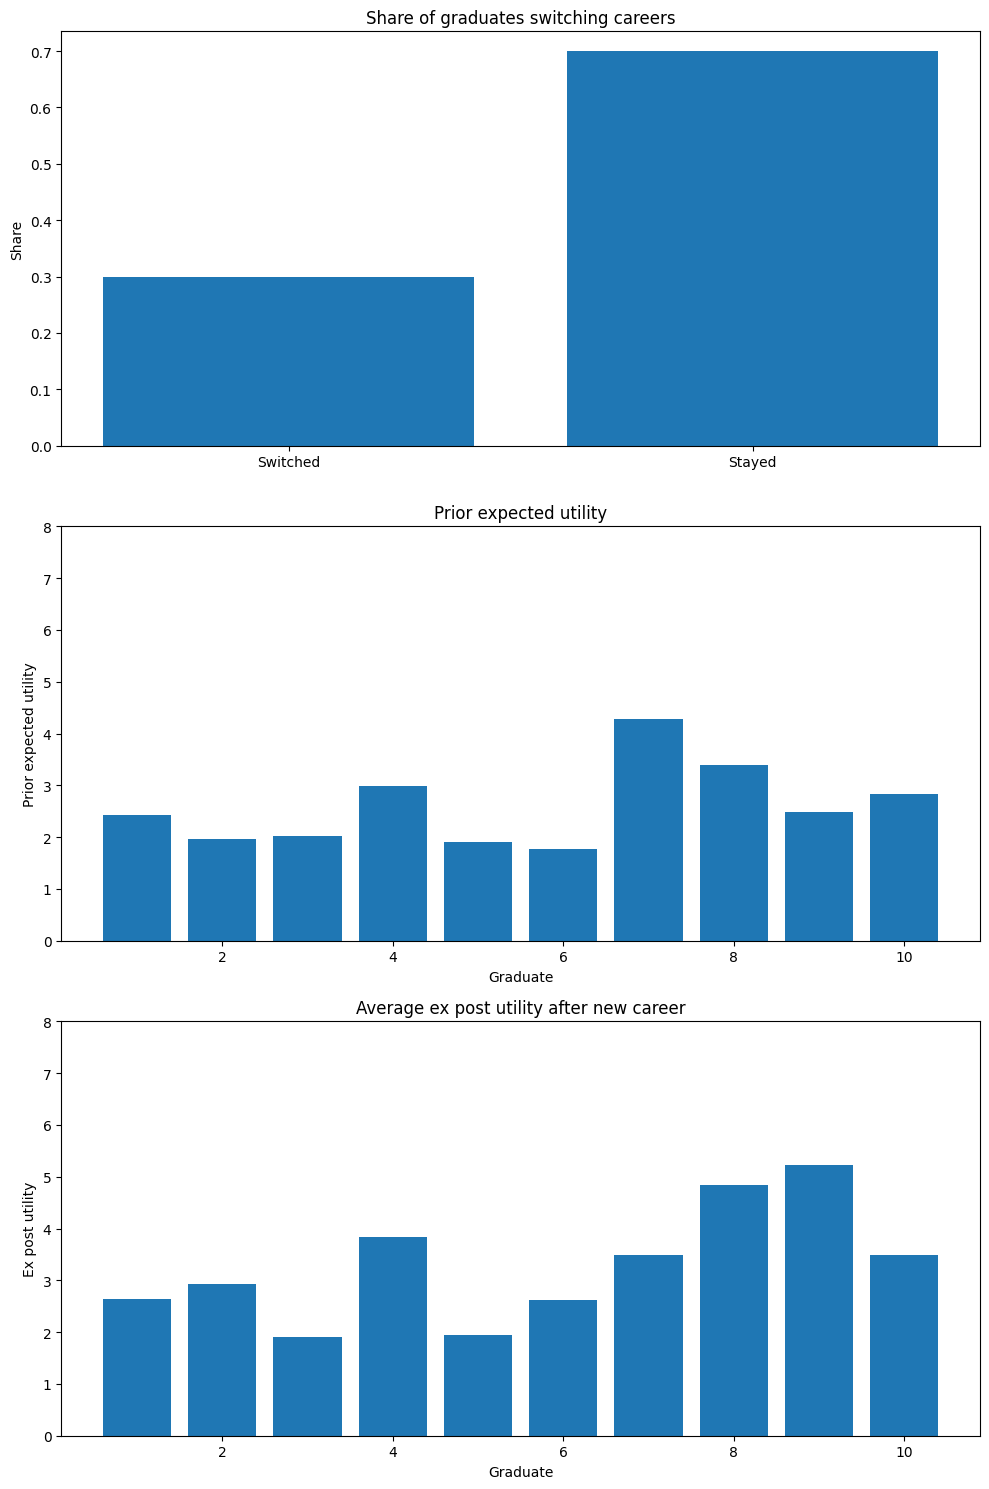

In [23]:
# write your answer here

new_career_choice = np.zeros(par.N, dtype=int) # define array for which new career they choose
new_realized_utility = np.zeros(par.N)
switch_decision = np.zeros(par.N, dtype=bool) # if they switch career, it will be true

for i in range(par.N):
    initial_career = career_selection[i]-1 # initial career choice
    initial_utility = utility_of_career_choice[i] # initial utility
    remaining_careers = np.setdiff1d(np.arange(par.J), initial_career) # find the remaining careers that graduate didn't pick
    new_utilities_with_cost = par.v[remaining_careers] - par.c + epsilon_graduates_list[i][remaining_careers] #np.random.normal(0, par.sigma, len(remaining_careers)) # calculate new utility with cost of -1 for c
    career_selection_after = career_selection.copy()

    if initial_utility >= np.max(new_utilities_with_cost): # logic comparison to see if they should switch career
        new_career_choice[i] = initial_career # insert the same value as before
        new_realized_utility[i] = initial_utility # same here
        switch_decision[i] = False
    else:
        new_career_choice[i] = remaining_careers[np.argmax(new_utilities_with_cost)] # the career with highest utility gets chosen
        new_realized_utility[i] = new_utilities_with_cost[np.argmax(new_utilities_with_cost)] # and corresponding utility
        switch_decision[i] = True

def share_of_career_switch():

    career_selection_after_switch = [] # initialize empty list for career selection after switch

    for i in range(len(career_selection)):
        if new_career_choice[i]+1 == career_selection[i]: # if the new career choice is the same as the old one, then execeture
            career_selection_after_switch.append(career_selection[i]) # append old career
        else:
            print("Graduate " + str(i+1) + " switched to career " + str(new_career_choice[i]+1) + " from career " + str(career_selection[i]))
            career_selection_after_switch.append(new_career_choice[i]+1) # append new career

    career_selection_after_switch = np.array(career_selection_after_switch) # make it to numpy array

    career1_switch_conditional = np.count_nonzero((career_selection == 1) & switch_decision) # count if the career is the first career and they switched
    career2_switch_conditional = np.count_nonzero((career_selection == 2) & switch_decision) # same for career 2
    career3_switch_conditional = np.count_nonzero((career_selection == 3) & switch_decision) # same for career 3
 
    share_switch_career1 = career1_switch_conditional / np.count_nonzero(career_selection == 1) # calculate shares
    share_switch_career2 = career2_switch_conditional / np.count_nonzero(career_selection == 2)
    share_switch_career3 = career3_switch_conditional / np.count_nonzero(career_selection == 3)

    print("List of career selections before switch: " + str(career_selection))
    print("List of career selections after switch: " + str(career_selection_after_switch))
    print("Share of graduates in career 1 that chose to switch career from last year: " + str(share_switch_career1) + "\n" +
           "Share of graduates in career 2 that chose to switch career from last year: " + str(share_switch_career2) + "\n" +
           "Share of graduates in career 3 that chose to switch career from last year: " + str( share_switch_career3))
    
    return None

share_of_career_switch()

shares_switching = np.mean(switch_decision) # calculate shares of graduates switching careers
average_subjective_utility_new = np.mean([average_utility_friends[i, new_career_choice[i]] for i in range(par.N)]) # calculate average subjective utility
average_realized_utility_new = np.mean(new_realized_utility) # calculate exp post realized utility


fig, axs = plt.subplots(3, 1, figsize=(10, 15))


axs[0].bar(['Switched', 'Stayed'], [shares_switching, 1 - shares_switching])
axs[0].set_title('Share of graduates switching careers')
axs[0].set_ylabel('Share')


axs[1].bar(np.arange(1, par.N+1), [average_utility_friends[i, new_career_choice[i]] for i in range(par.N)])
axs[1].set_title('Prior expected utility')
axs[1].set_xlabel('Graduate')
axs[1].set_ylabel('Prior expected utility')
axs[1].set_ylim(top=8)


axs[2].bar(np.arange(1, par.N+1), new_realized_utility)
axs[2].set_title('Average ex post utility after new career')
axs[2].set_xlabel('Graduate')
axs[2].set_ylabel('Ex post utility')
axs[2].set_ylim(top=8)

plt.tight_layout()
plt.show()

## 3. <a id='toc3_'></a>[Problem 3: Barycentric interpolation](#toc0_)

**Problem:** We have a set of random points in the unit square,

$$
\mathcal{X} = \{(x_1,x_2)\,|\,x_1\sim\mathcal{U}(0,1),x_2\sim\mathcal{U}(0,1)\}.
$$

For these points, we know the value of some function $f(x_1,x_2)$,

$$
\mathcal{F} = \{f(x_1,x_2) \,|\, (x_1,x_2) \in \mathcal{X}\}.
$$

Now we want to approximate the value $f(y_1,y_2)$ for some  $y=(y_1,y_2)$, where $y_1\sim\mathcal{U}(0,1)$ and $y_2\sim\mathcal{U}(0,1)$.

**Building block I**

For an arbitrary triangle $ABC$ and a point $y$, define the so-called barycentric coordinates as:

$$
\begin{align*}
  r^{ABC}_1 &= \frac{(B_2-C_2)(y_1-C_1) + (C_1-B_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_2 &= \frac{(C_2-A_2)(y_1-C_1) + (A_1-C_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_3 &= 1 - r_1 - r_2.
\end{align*}
$$

If $r^{ABC}_1 \in [0,1]$, $r^{ABC}_2 \in [0,1]$, and $r^{ABC}_3 \in [0,1]$, then the point is inside the triangle.

We always have $y = r^{ABC}_1 A + r^{ABC}_2 B + r^{ABC}_3 C$.

**Building block II**

Define the following points:

$$
\begin{align*}
A&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}>y_{2}\\
B&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}<y_{2}\\
C&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}<y_{2}\\
D&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}>y_{2}.
\end{align*}
$$

**Algorithm:**

1. Compute $A$, $B$, $C$, and $D$. If not possible return `NaN`.
1. If $y$ is inside the triangle $ABC$ return $r^{ABC}_1 f(A) + r^{ABC}_2 f(B) + r^{ABC}_3 f(C)$.
1. If $y$ is inside the triangle $CDA$ return $r^{CDA}_1 f(C) + r^{CDA}_2 f(D) + r^{CDA}_3 f(A)$.
1. Return `NaN`.



**Sample:**

In [14]:
rng = np.random.default_rng(2024)

X = rng.uniform(size=(50,2))
y = rng.uniform(size=(2,))


**Questions 1:** Find $A$, $B$, $C$ and $D$. Illustrate these together with $X$, $y$ and the triangles $ABC$ and $CDA$.


We will find an approximated value for $ f(y_1, y_2) $ at a given specific point $ y = (y_1, y_2) $ with the set of random points and the corresponding value, with the help of barycentric interpolation.


We start by using a set of random points provided in the task to find an approximate value for $f(y_1, y_2)$ at a given point 
$y = (y_1, y_2)$. This is done using barycentric coordinates.

Next, we need to identify the points $A$, $B$, $C$, and $D$ based on the nearest points in $\mathcal{X}$ that satisfy certain constraints. These points are computed by finding the nearest points to $y$ with specific conditions on their coordinates. If any of these points cannot be determined, we return NaN.

Our algorithm work in the following way if $y$ is inside the triangle $ABC$, it returns the function values at $A$, $B$, and $C$. Similarly, if $y$ is inside the triangle $CDA$, it returns the function values at $C$, $D$, and $A$. If $y$ is outside both triangles, it returns NaN. 


In [15]:
# we set up a function to find the closest point based on conditions
def find_point(X, y, condition):
    # here we calculate distances from y to all points in X
    distances = np.linalg.norm(X - y, axis=1)
    # apply condition to filter points in X
    mask = condition(X, y)
    # here we are cheacking if there are any points that satisfy the condition
    if np.any(mask):
        
        return X[mask][np.argmin(distances[mask])]
    else:
        
        return np.array([np.nan, np.nan])
    # here we set up a function that return the point with the least distance form y among the points, if there is no points that satisfy it will return Nan

# set up for the conditions for points A, B, C, and D as they are given in the text 
conditions = [
    lambda X, y: (X[:, 0] > y[0]) & (X[:, 1] > y[1]),
    lambda X, y: (X[:, 0] > y[0]) & (X[:, 1] < y[1]),
    lambda X, y: (X[:, 0] < y[0]) & (X[:, 1] < y[1]),
    lambda X, y: (X[:, 0] < y[0]) & (X[:, 1] > y[1])
]
# we find the points A, B, C, and D using the find_point function with the given conditions above.
A = find_point(X, y, conditions[0])
B = find_point(X, y, conditions[1])
C = find_point(X, y, conditions[2])
D = find_point(X, y, conditions[3])

#  just printing the coordinates of points A, B, C, and D
print(f"Coordinates of Point A: {A}")
print(f"Coordinates of Point B: {B}")
print(f"Coordinates of Point C: {C}")
print(f"Coordinates of Point D: {D}")


Coordinates of Point A: [0.26071605 0.43635845]
Coordinates of Point B: [0.21315735 0.274245  ]
Coordinates of Point C: [0.10056103 0.27951775]
Coordinates of Point D: [0.20634391 0.44272557]


after we have found the coordinates for $ A, B, C $ and $D $ we will find the barycentric coordinates and plot the triangels

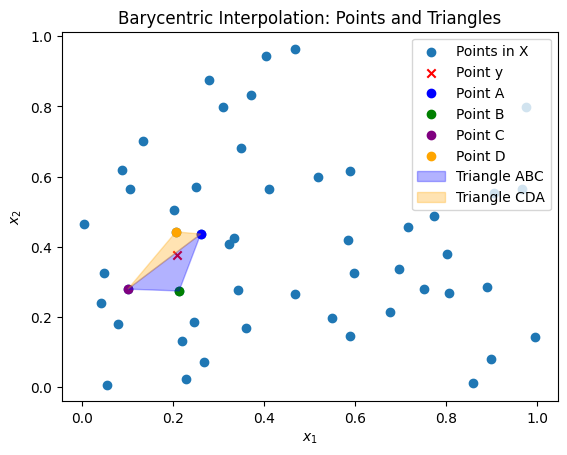

In [16]:
# setting up the function to calculate barycentric coordinates for a point y in a triangle given point 1,2 and 3. 
# I have choosen to call them p1, p2, p3 for easier read-ability 
def barycentric_coords(p1, p2, p3, y):
    denom = (p2[1] - p3[1]) * (p1[0] - p3[0]) + (p3[0] - p2[0]) * (p1[1] - p3[1])
    r1 = ((p2[1] - p3[1]) * (y[0] - p3[0]) + (p3[0] - p2[0]) * (y[1] - p3[1])) / denom
    r2 = ((p3[1] - p1[1]) * (y[0] - p3[0]) + (p1[0] - p3[0]) * (y[1] - p3[1])) / denom
    r3 = 1 - r1 - r2
    return r1, r2, r3


# Visualization of points and triangles
fig, ax = plt.subplots()

# Plot all points in X
ax.scatter(X[:, 0], X[:, 1], label='Points in X')
# Plot point y
ax.scatter(y[0], y[1], color='red', label='Point y', marker='x')
# Plot points A, B, C, and D
ax.scatter(A[0], A[1], color='blue', label='Point A')
ax.scatter(B[0], B[1], color='green', label='Point B')
ax.scatter(C[0], C[1], color='purple', label='Point C')
ax.scatter(D[0], D[1], color='orange', label='Point D')

# Plot triangles ABC and CDA
triangle_ABC = plt.Polygon([A, B, C], color='blue', alpha=0.3, label='Triangle ABC')
triangle_CDA = plt.Polygon([C, D, A], color='orange', alpha=0.3, label='Triangle CDA')
ax.add_patch(triangle_ABC)
ax.add_patch(triangle_CDA)

# Add legend, labels, and title
ax.legend()
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Barycentric Interpolation: Points and Triangles')

# Show the plot
plt.show()

The plot shows how the target point $y$ is related to the nearest points in the dataset and the triangles formed for interpolation $ABC$ and $ADC$. The plot show the given relationship between them and provides a visual validation that $y$ lies within the interpolation triangles, making it suitable for computing the aproximate value.

**Question 2:** Compute the barycentric coordinates of the point $y$ with respect to the triangles $ABC$ and $CDA$. Which triangle is $y$ located inside?

we will start of by finding the coordinates with respert to triangle ABC and CDA 

In [17]:
# the function to check if y is inside the triangle using BC
def is_inside_triangle(r1, r2, r3):
    # Checking if all BC are between 0 and 1
    return (0 <= r1 <= 1) and (0 <= r2 <= 1) and (0 <= r3 <= 1)

# Calculate barycentric coordinates for triangle ABC
r1_ABC, r2_ABC, r3_ABC = barycentric_coords(A, B, C, y)

# Calculate barycentric coordinates for triangle CDA
r1_CDA, r2_CDA, r3_CDA = barycentric_coords(C, D, A, y)

print(f"Barycentric coordinates of y with respect to triangle ABC: r1={r1_ABC}, r2={r2_ABC}, r3={r3_ABC}")
print(f"Barycentric coordinates of y with respect to triangle CDA: r1={r1_CDA}, r2={r2_CDA}, r3={r3_CDA}")




Barycentric coordinates of y with respect to triangle ABC: r1=0.6286263152916166, r2=0.06910145494351515, r3=0.3022722297648682
Barycentric coordinates of y with respect to triangle CDA: r1=0.3682598757102867, r2=-0.13392661883334067, r3=0.765666743123054



we here after set up the fucntion to check if its inside ABC or the CDA triangle 

In [18]:
# check if point y is inside any of the triangles ABC or CDA if not return NaN
def check_point_in_triangles(A, B, C, D, y):
    if any(np.isnan(p).any() for p in [A, B, C, D]):
        return "NaN"
    # Check if point y is inside triangle ABC, CDA or either
    if is_inside_triangle(r1_ABC, r2_ABC, r3_ABC):
        return f"Point y is inside triangle ABC"
    elif is_inside_triangle(r1_CDA, r2_CDA, r3_CDA):
        return f"Point y is inside triangle CDA"
    else:
        return "Point y is not inside any triangle"

# Check if point y is inside the triangles and print the result
result = check_point_in_triangles(A, B, C, D, y)
print(result)

Point y is inside triangle ABC


These coordinates indicate how 
$y$ is represented as a combination of points $A$,$B$, and $C$ in the interpolation process, confirming that $y$ lies inside the triangle ABC and enabling the computation of the interpolated function value at $y$.

Now consider the function:
$$
f(x_1,x_2) = x_1 \cdot x_2
$$

In [19]:
f = lambda x: x[0]*x[1]
F = np.array([f(x) for x in X])

**Question 3:** Compute the approximation of $f(y)$ using the full algorithm. Compare with the true value.

In [20]:
# we again set up a function to check if y is inside the triangle using barycentric coordinates
def is_inside_triangle(r1, r2, r3):
    return (0 <= r1 <= 1) and (0 <= r2 <= 1) and (0 <= r3 <= 1)

# check if all points are found and calculate barycentric coordinates
def check_point_in_triangles(A, B, C, D, y):
    if any(np.isnan(p).any() for p in [A, B, C, D]):
        return "NaN", np.nan

    r1_ABC, r2_ABC, r3_ABC = barycentric_coords(A, B, C, y)
    r1_CDA, r2_CDA, r3_CDA = barycentric_coords(C, D, A, y)
    
    if is_inside_triangle(r1_ABC, r2_ABC, r3_ABC):
        f_y = r1_ABC * f(A) + r2_ABC * f(B) + r3_ABC * f(C)
        message = f"Point y is inside triangle ABC with barycentric coordinates: r1={r1_ABC}, r2={r2_ABC}, r3={r3_ABC}"
    elif is_inside_triangle(r1_CDA, r2_CDA, r3_CDA):
        f_y = r1_CDA * f(C) + r2_CDA * f(D) + r3_CDA * f(A)
        message = f"Point y is inside triangle CDA with barycentric coordinates: r1={r1_CDA}, r2={r2_CDA}, r3={r3_CDA}"
    else:
        f_y = np.nan
        message = "Point y is not inside any triangle"
    
    return message, f_y

# Check if point y is inside the triangles
message, f_y = check_point_in_triangles(A, B, C, D, y)
print(message)

# Compare the interpoladet with  the true value
true_value = f(y)
print(f"Interpolated value at {y}: {f_y}")
print(f"True value at {y}: {true_value}")

Point y is inside triangle ABC with barycentric coordinates: r1=0.6286263152916166, r2=0.06910145494351515, r3=0.3022722297648682
Interpolated value at [0.20901926 0.37774759]: 0.08405201731052576
True value at [0.20901926 0.37774759]: 0.0789565216259594


The barycentric interpolation process demonstrated here is consistent and provides a close approximation to the true function value. The small relative error suggests that the interpolation method is reliable and effective for estimating function values at points within the triangle. The visualization and consistent barycentric coordinates reinforce the accuracy and stability of the interpolation process.

**Question 4:** Repeat question 3 for all points in the set $Y$.

In [21]:
Y = [(0.2,0.2),(0.8,0.2),(0.8,0.8),(0.5,0.5)]

Point y [0.2 0.2] is inside triangle ABC with barycentric coordinates: r1=0.1805466701524854, r2=0.5826765149253863, r3=0.23677681492212832
Interpolated value at [0.2 0.2]: 0.04032631372248057
True value at [0.2 0.2]: 0.04000000000000001


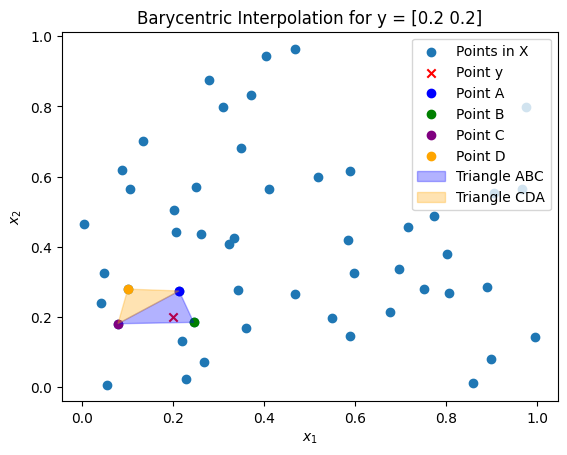

Point y [0.8 0.2] is inside triangle ABC with barycentric coordinates: r1=0.5874166293573827, r2=0.2678463596528006, r3=0.14473701098981667
Interpolated value at [0.8 0.2]: 0.15874233999349835
True value at [0.8 0.2]: 0.16000000000000003


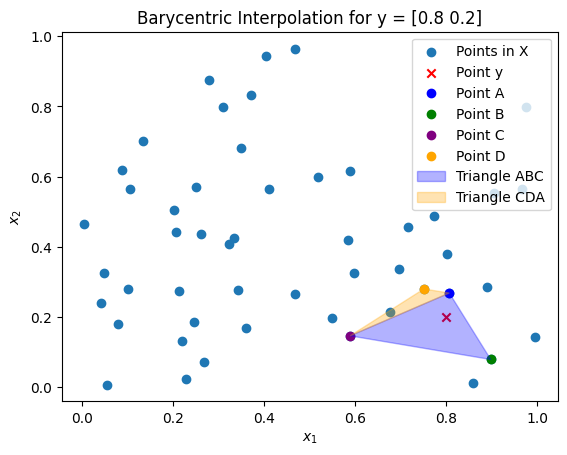

NaN for y = [0.8 0.8]
Point y [0.5 0.5] is inside triangle ABC with barycentric coordinates: r1=0.4407329133559943, r2=0.3362411978710884, r3=0.2230258887729173
Interpolated value at [0.5 0.5]: 0.2512901561119622
True value at [0.5 0.5]: 0.25


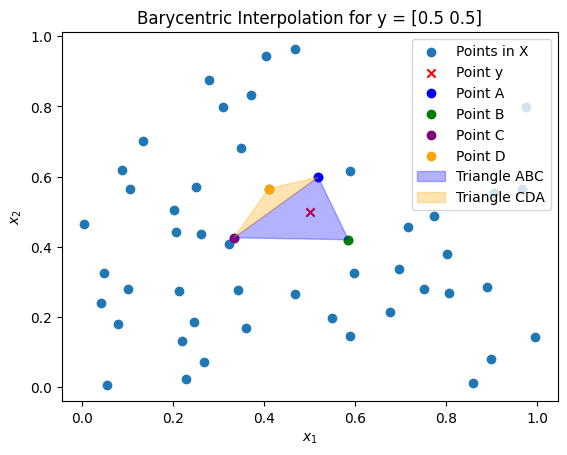

In [22]:
for y in Y:
    y = np.array(y)
    
    # Find points A, B, C, and D for current y in the array
    A = find_point(X, y, conditions[0])
    B = find_point(X, y, conditions[1])
    C = find_point(X, y, conditions[2])
    D = find_point(X, y, conditions[3])

    # Check if all points are found
    if np.any(np.isnan(A)) or np.any(np.isnan(B)) or np.any(np.isnan(C)) or np.any(np.isnan(D)):
        print(f"NaN for y = {y}")
    else:
        # Calculate barycentric coordinates for triangles ABC and CDA
        r1_ABC, r2_ABC, r3_ABC = barycentric_coords(A, B, C, y)
        r1_CDA, r2_CDA, r3_CDA = barycentric_coords(C, D, A, y)
        
        # Check if y is inside triangle ABC or CDA
        inside_ABC = is_inside_triangle(r1_ABC, r2_ABC, r3_ABC)
        inside_CDA = is_inside_triangle(r1_CDA, r2_CDA, r3_CDA)
        
        if inside_ABC:
            f_y = r1_ABC * f(A) + r2_ABC * f(B) + r3_ABC * f(C)
            print(f"Point y {y} is inside triangle ABC with barycentric coordinates: r1={r1_ABC}, r2={r2_ABC}, r3={r3_ABC}")
        elif inside_CDA:
            f_y = r1_CDA * f(C) + r2_CDA * f(D) + r3_CDA * f(A)
            print(f"Point y {y} is inside triangle CDA with barycentric coordinates: r1={r1_CDA}, r2={r2_CDA}, r3={r3_CDA}")
        else:
            f_y = np.nan
            print(f"Point y {y} is not inside any triangle")
        
        true_value = f(y)
        print(f"Interpolated value at {y}: {f_y}")
        print(f"True value at {y}: {true_value}")
        
        # Visualization for each y
        fig, ax = plt.subplots()
        ax.scatter(X[:, 0], X[:, 1], label='Points in X')
        ax.scatter(y[0], y[1], color='red', label='Point y', marker='x')
        ax.scatter(A[0], A[1], color='blue', label='Point A')
        ax.scatter(B[0], B[1], color='green', label='Point B')
        ax.scatter(C[0], C[1], color='purple', label='Point C')
        ax.scatter(D[0], D[1], color='orange', label='Point D')
        triangle_ABC = plt.Polygon([A, B, C], color='blue', alpha=0.3, label='Triangle ABC')
        triangle_CDA = plt.Polygon([C, D, A], color='orange', alpha=0.3, label='Triangle CDA')
        ax.add_patch(triangle_ABC)
        ax.add_patch(triangle_CDA)
        ax.legend()
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        ax.set_title(f'Barycentric Interpolation for y = {y}')
        plt.show()

Here we can see all the plots, and as the code says, we get NaN for 0.8, 0.8 given its outside the grid 